In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import numpy as np
import seaborn as sns
import datetime
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import warnings


warnings.filterwarnings('ignore', category=RuntimeWarning)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

file = '../data/Original/Wimbledon_featured_matches.csv'
df = pd.read_csv(file)

In [7]:
df

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:00,1,1,1,0,0,0,...,0,0,0,6.000,7.840,2,95.0,BC,NCTL,ND
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:38,1,1,2,0,0,0,...,0,0,0,5.253,7.094,1,118.0,B,CTL,ND
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:01,1,1,3,0,0,0,...,0,0,0,13.800,19.808,4,120.0,B,NCTL,D
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:31,1,1,4,0,0,0,...,0,0,0,51.108,75.631,13,130.0,BW,CTL,D
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:02:21,1,1,5,0,0,0,...,0,0,0,0.649,0.813,1,112.0,W,NCTL,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:39:58,5,10,330,2,2,5,...,0,0,0,38.620,50.971,11,123.0,C,NCTL,D
7280,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:40:43,5,10,331,2,2,5,...,0,0,0,17.533,27.766,5,114.0,W,NCTL,ND
7281,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:41:20,5,10,332,2,2,5,...,0,0,0,10.882,18.328,4,124.0,W,NCTL,D
7282,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:41:52,5,10,333,2,2,5,...,0,0,0,7.893,10.537,1,130.0,C,NCTL,D


In [8]:
df0 = df.copy()
df0 = df0.dropna(subset=['serve_width', 'serve_depth'])
df0 = pd.get_dummies(df0, columns=['serve_width', 'serve_depth', 'return_depth', 'winner_shot_type'])
df0.loc[df0['p1_score'] == 'AD', 'p1_score'] = 55
df0.loc[df0['p2_score'] == 'AD', 'p2_score'] = 55


vars = ['p1_score','p2_score', 'serve_width_B', 'serve_width_BC', 'serve_width_BW', 'serve_width_C', 
        'serve_width_W', 'serve_depth_CTL', 'serve_depth_NCTL','return_depth_D', 'return_depth_ND', 
        'winner_shot_type_0','winner_shot_type_B', 'winner_shot_type_F']

for var in vars:
    df0[var] = df0[var].astype(int)

df0.reset_index(drop=True, inplace=True)

def subtract_24_hours(time_str):
    if time_str.startswith('25:'):
        time_str = '1:' + time_str[3:]
    if time_str.startswith('24:'):
        time_str = '0:' + time_str[3:]
    return time_str

df0['elapsed_time'] = df0['elapsed_time'].apply(subtract_24_hours)

In [9]:
df0

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,serve_width_BW,serve_width_C,serve_width_W,serve_depth_CTL,serve_depth_NCTL,return_depth_D,return_depth_ND,winner_shot_type_0,winner_shot_type_B,winner_shot_type_F
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:00,1,1,1,0,0,0,...,0,0,0,0,1,0,1,1,0,0
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:38,1,1,2,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:01,1,1,3,0,0,0,...,0,0,0,0,1,1,0,1,0,0
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:31,1,1,4,0,0,0,...,1,0,0,1,0,1,0,0,0,1
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:02:21,1,1,5,0,0,0,...,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7225,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:39:58,5,10,330,2,2,5,...,0,1,0,0,1,1,0,0,0,1
7226,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:40:43,5,10,331,2,2,5,...,0,0,1,0,1,0,1,0,1,0
7227,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:41:20,5,10,332,2,2,5,...,0,0,1,0,1,1,0,0,0,1
7228,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:41:52,5,10,333,2,2,5,...,0,1,0,0,1,1,0,1,0,0


In [16]:
speed = df0['speed_mph'].mean()
df0['speed_mph'].fillna(value=speed, inplace=True)
df1 = df0.copy()
def time_string_to_seconds(time_string):
    hours, minutes, seconds = [int(part) for part in time_string.split(":")]
    total_seconds = hours * 3600 + minutes * 60 + seconds
    return total_seconds
df1['elapsed_seconds'] = df1['elapsed_time'].apply(time_string_to_seconds)

In [33]:
color = sns.choose_diverging_palette()

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

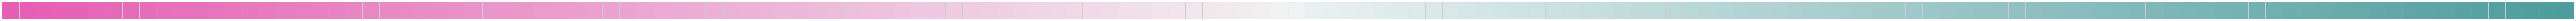

In [47]:
color = sns.diverging_palette(333, 195, s=74, l=60, n=150, sep=1, as_cmap=False)
sns.palplot(color)

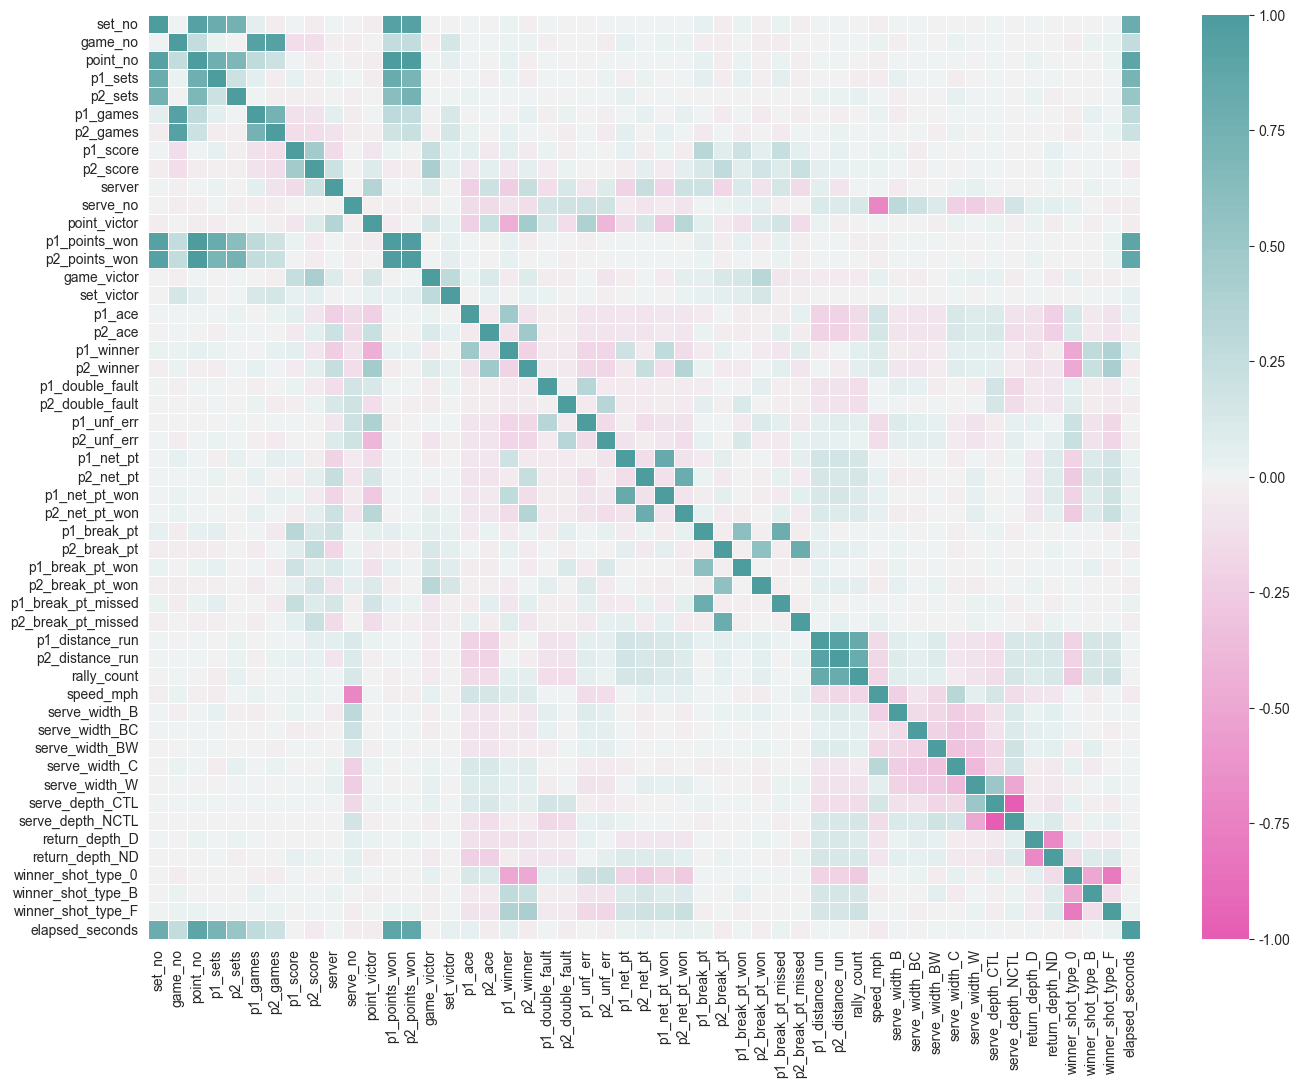

In [48]:
# 选择特征进行相关性分析
numerical_features = ['set_no', 'game_no',
                    'point_no', 'p1_sets', 'p2_sets', 'p1_games', 'p2_games', 'p1_score',
                    'p2_score', 'server', 'serve_no', 'point_victor', 'p1_points_won',
                    'p2_points_won', 'game_victor', 'set_victor', 'p1_ace', 'p2_ace',
                    'p1_winner', 'p2_winner', 'p1_double_fault', 'p2_double_fault',
                    'p1_unf_err', 'p2_unf_err', 'p1_net_pt', 'p2_net_pt', 'p1_net_pt_won',
                    'p2_net_pt_won', 'p1_break_pt', 'p2_break_pt', 'p1_break_pt_won',
                    'p2_break_pt_won', 'p1_break_pt_missed', 'p2_break_pt_missed',
                    'p1_distance_run', 'p2_distance_run', 'rally_count', 'speed_mph',
                    'serve_width_B', 'serve_width_BC', 'serve_width_BW', 'serve_width_C',
                    'serve_width_W', 'serve_depth_CTL', 'serve_depth_NCTL',
                    'return_depth_D', 'return_depth_ND', 'winner_shot_type_0',
                    'winner_shot_type_B', 'winner_shot_type_F', 'elapsed_seconds']
plt.figure(figsize=(16, 12)) 
correlation_matrix = df1[numerical_features].corr()
# 热力图
sns.heatmap(correlation_matrix, linewidths=.5, cmap=color, center=0)
plt.show()

In [405]:
X = add_constant(df1[numerical_features])

# 计算VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i).round(2) for i in range(X.shape[1])]

# 计算容忍度
vif_data["Tolerance"] = (1 / vif_data["VIF"]).round(2)
vif_data

,Feature,VIF,Tolerance
0,const,0.00,inf
1,set_no,inf,0.00
2,game_no,inf,0.00
3,point_no,14307.40,0.00
4,p1_sets,inf,0.00
5,p2_sets,inf,0.00
6,p1_games,inf,0.00
7,p2_games,inf,0.00
8,p1_score,1.75,0.57
9,p2_score,1.94,0.52


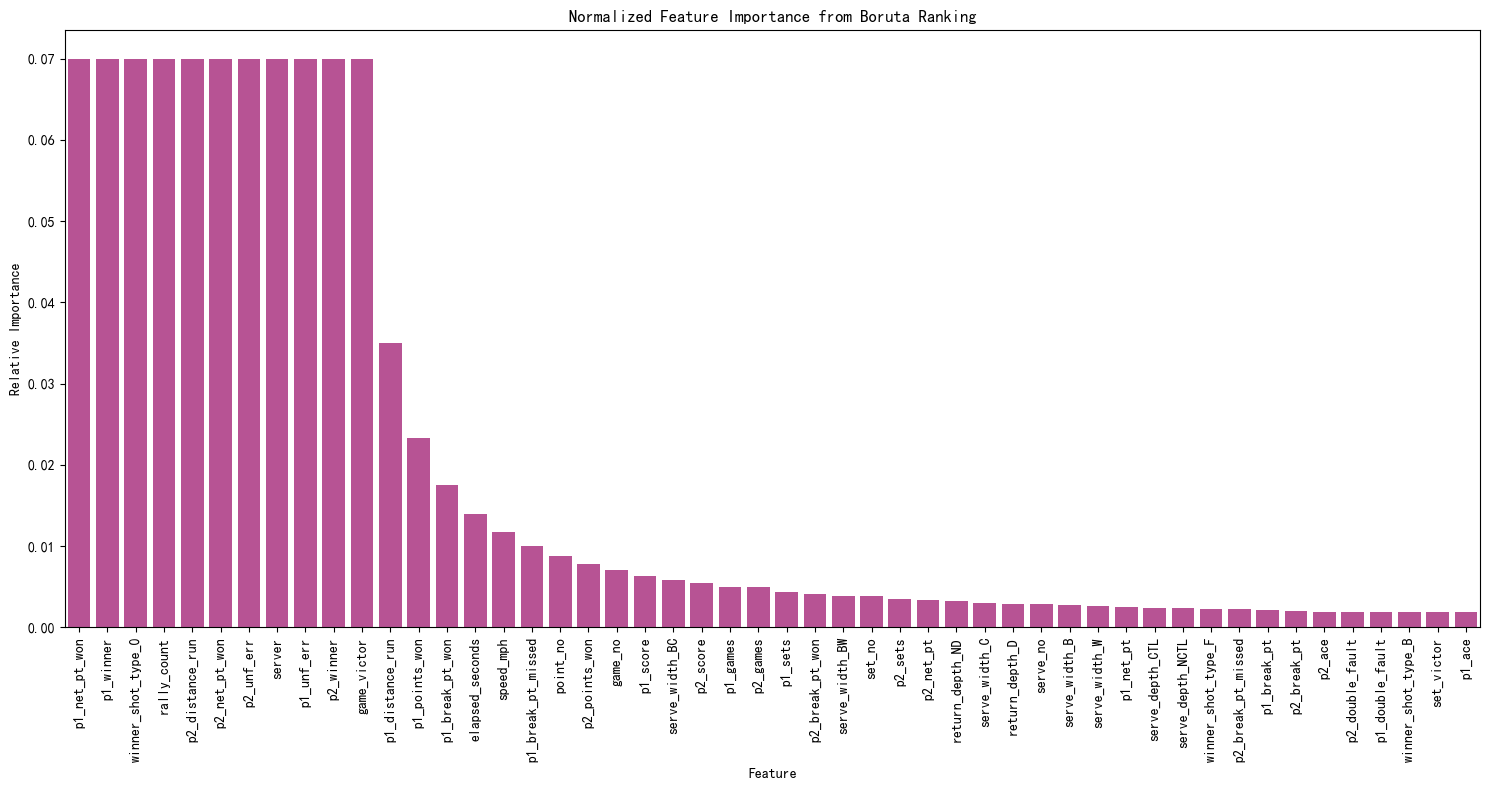

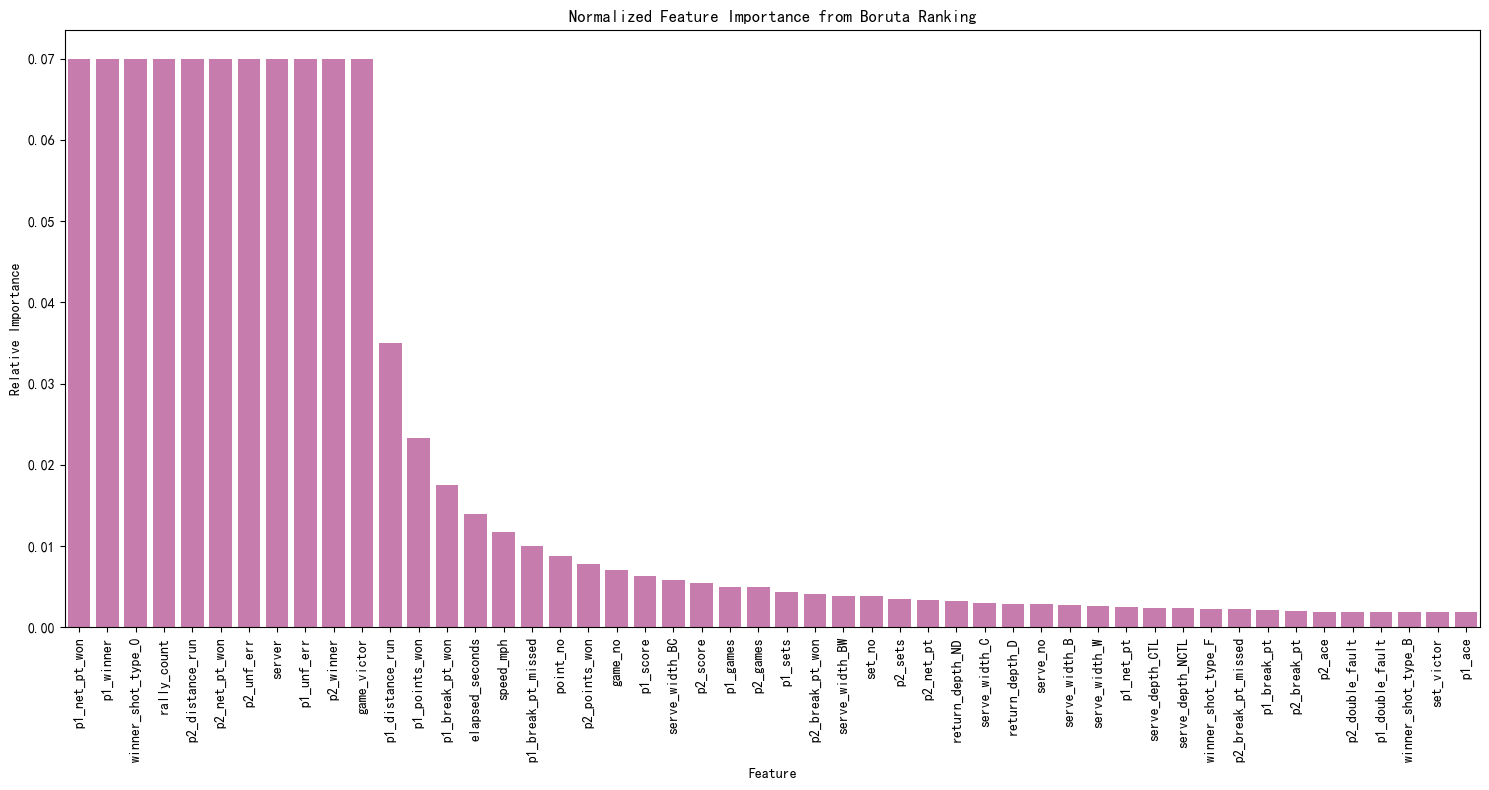

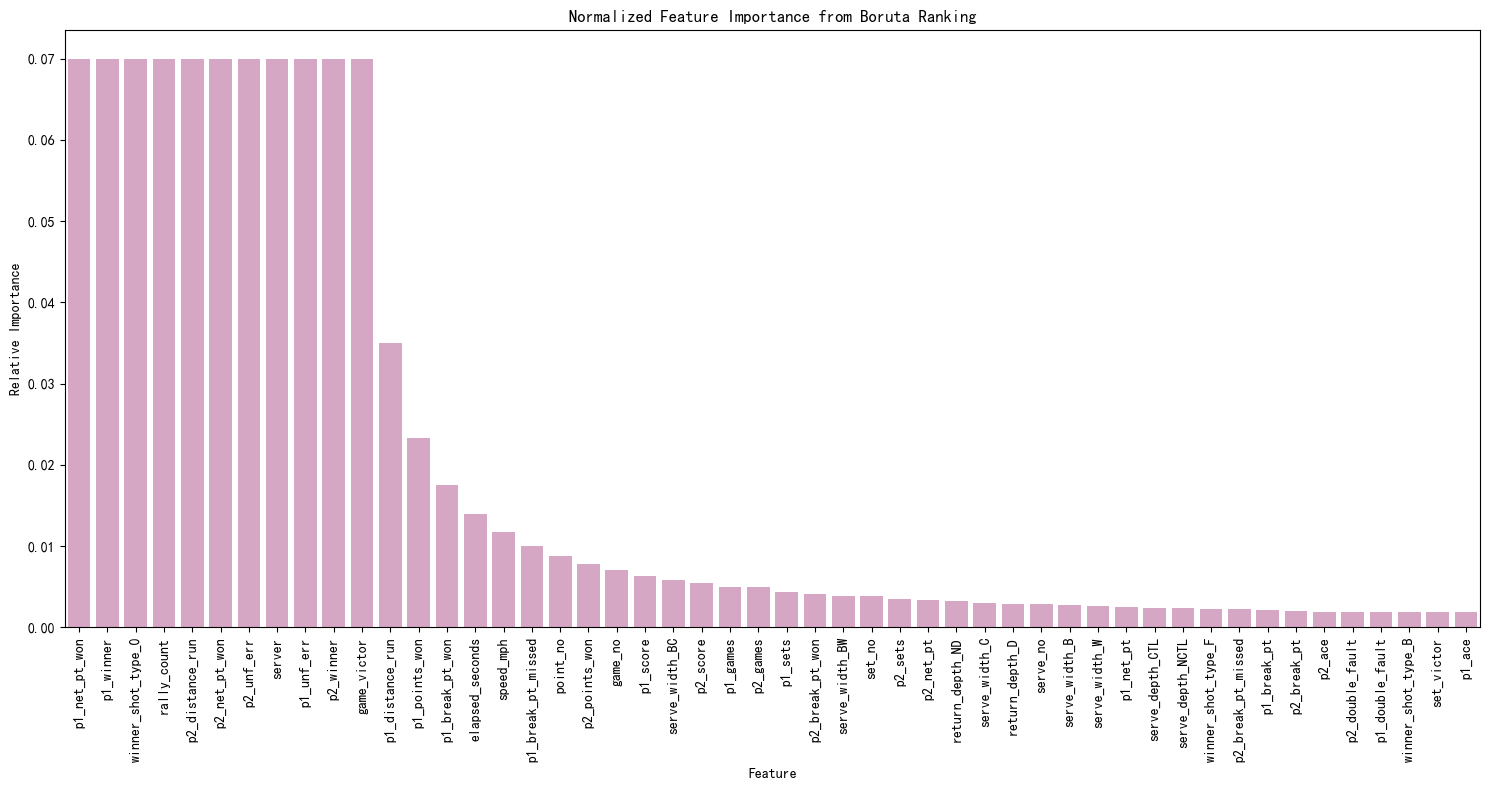

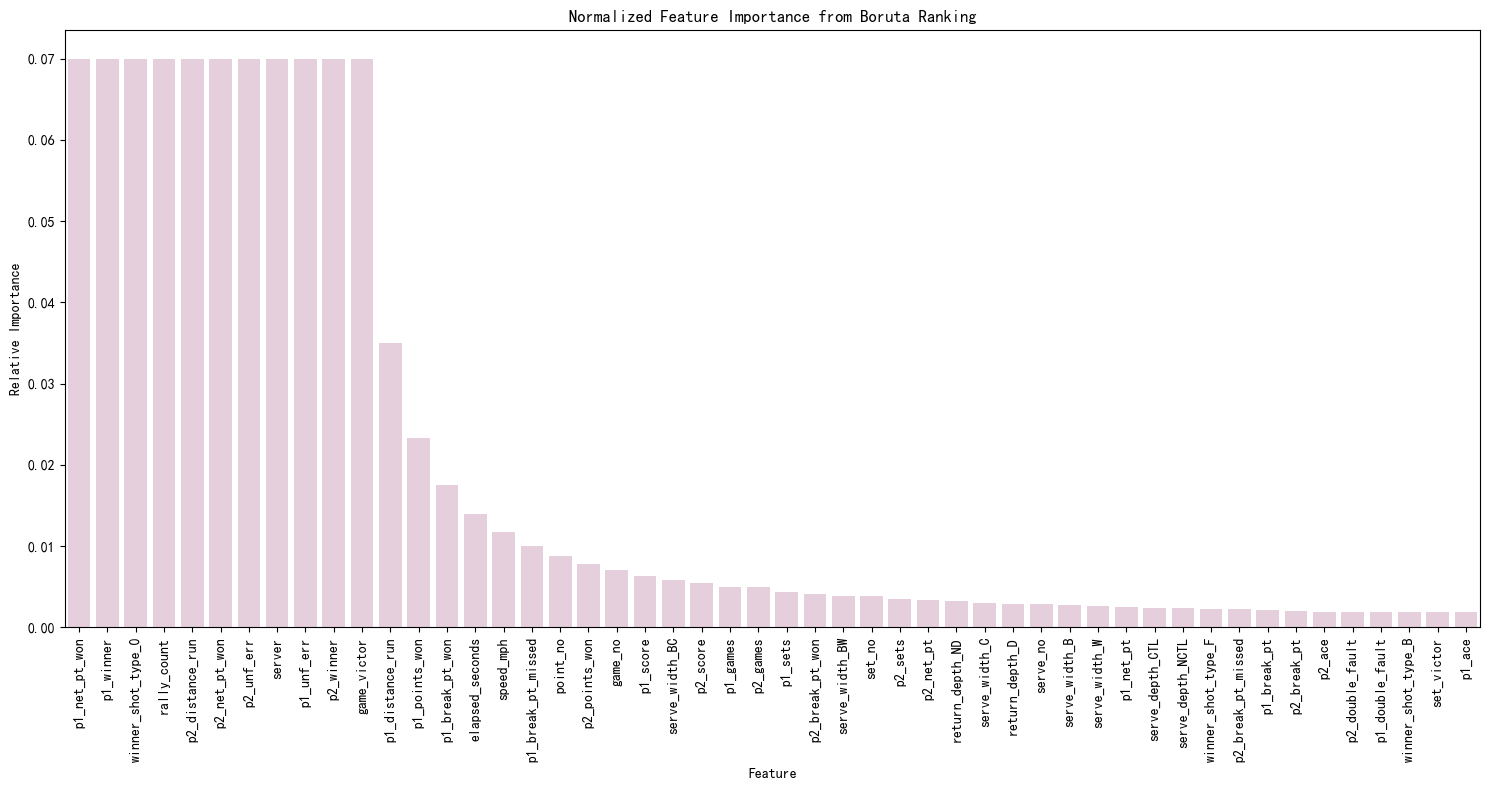

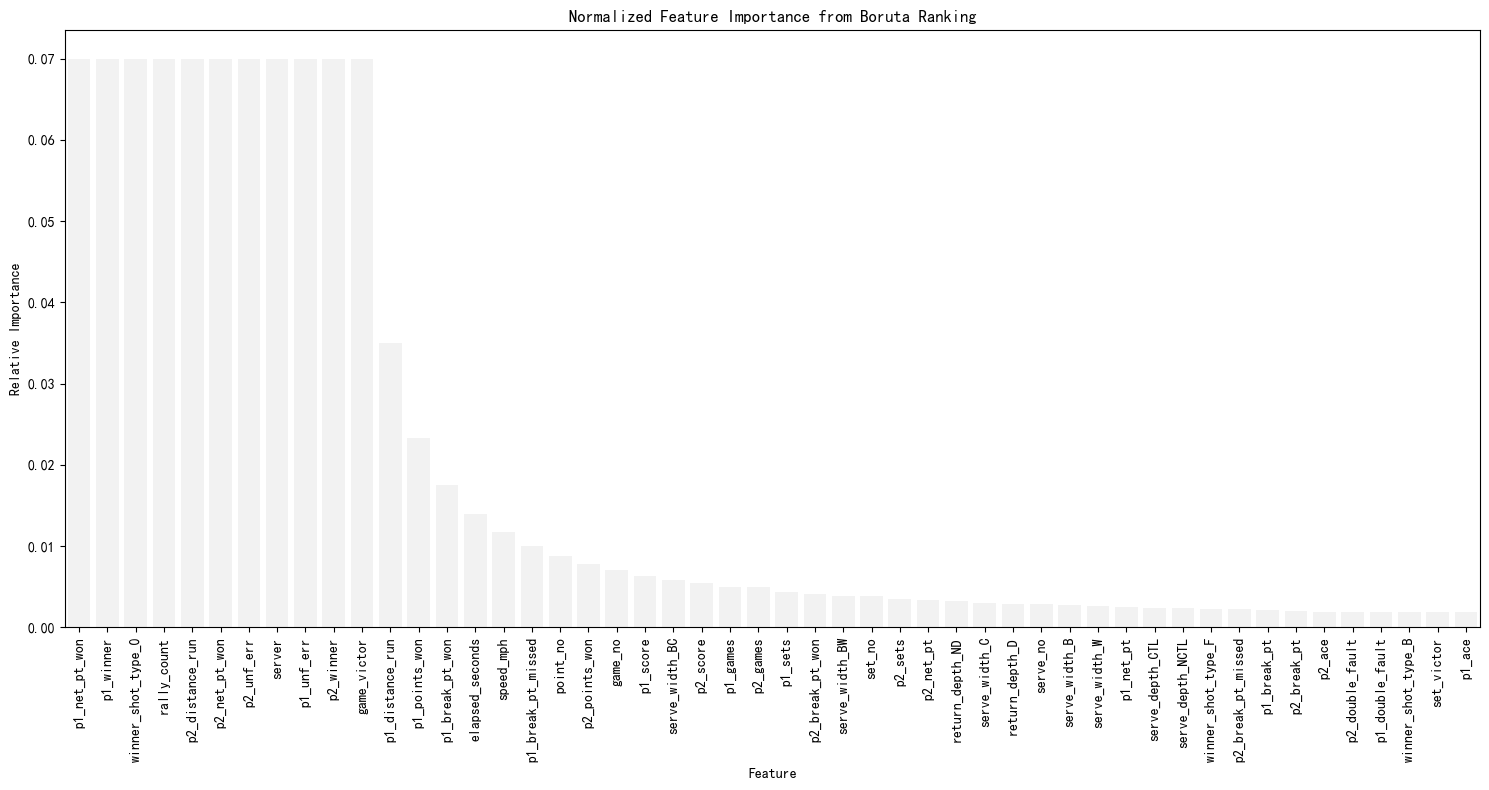

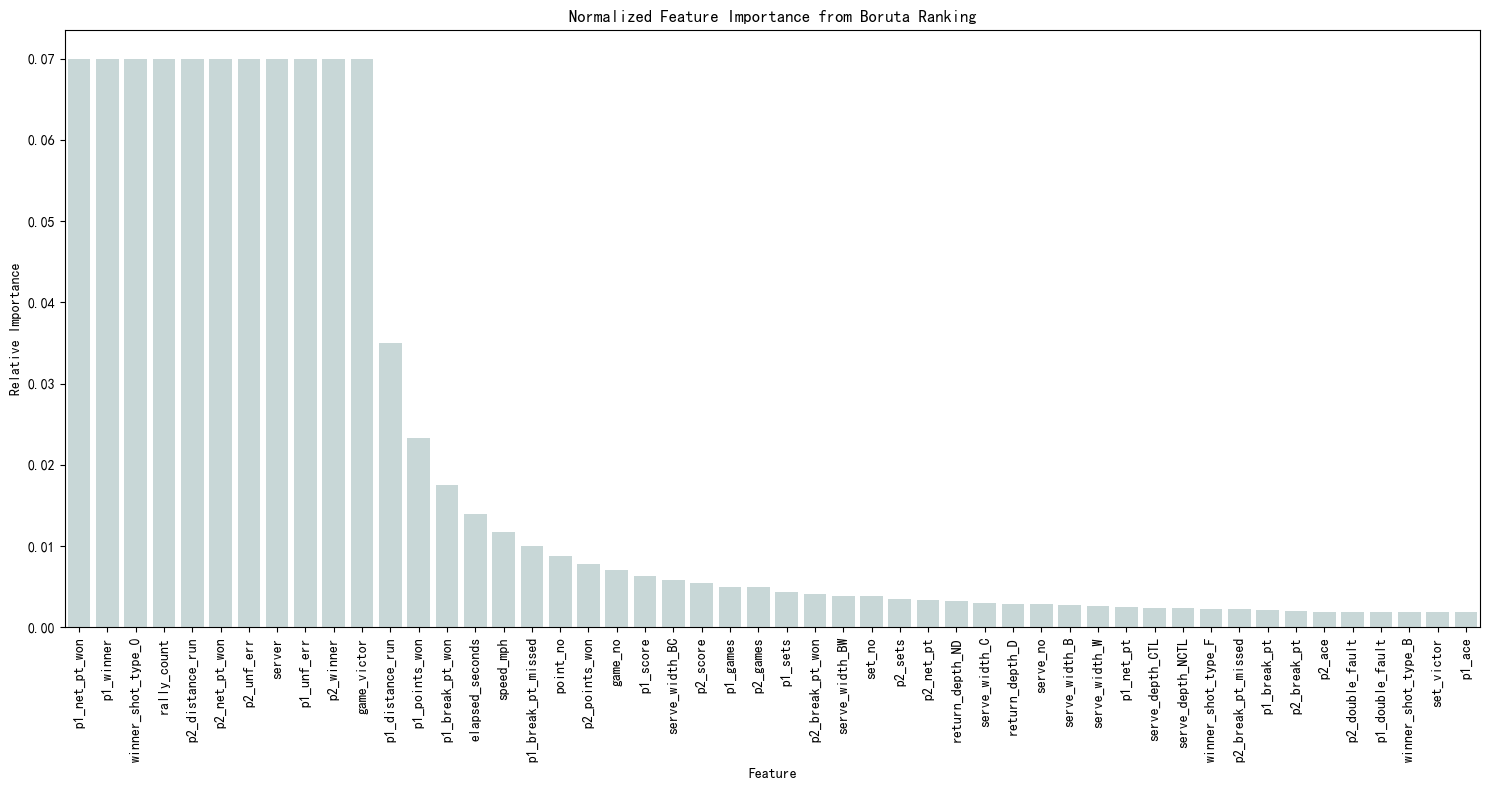

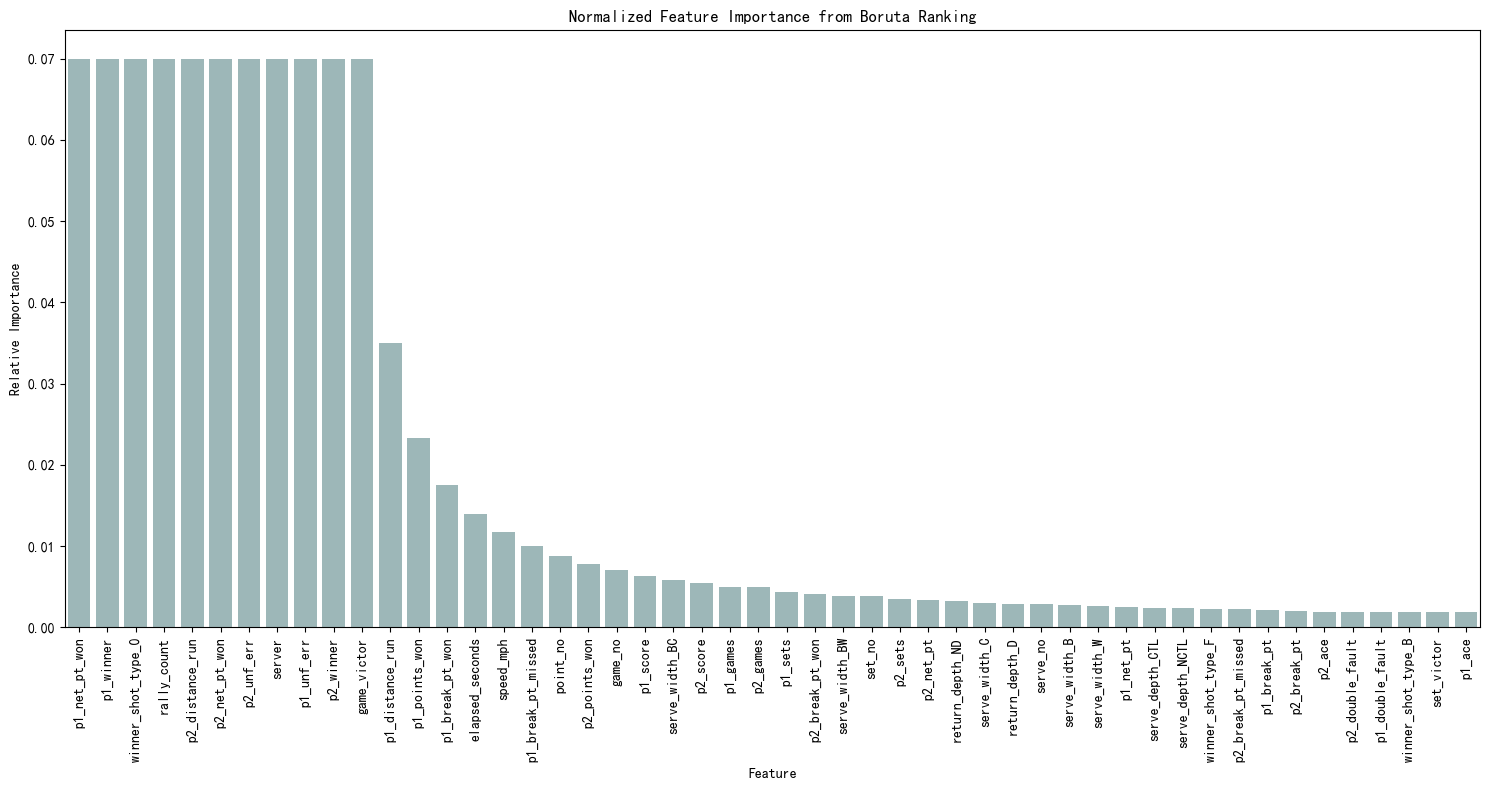

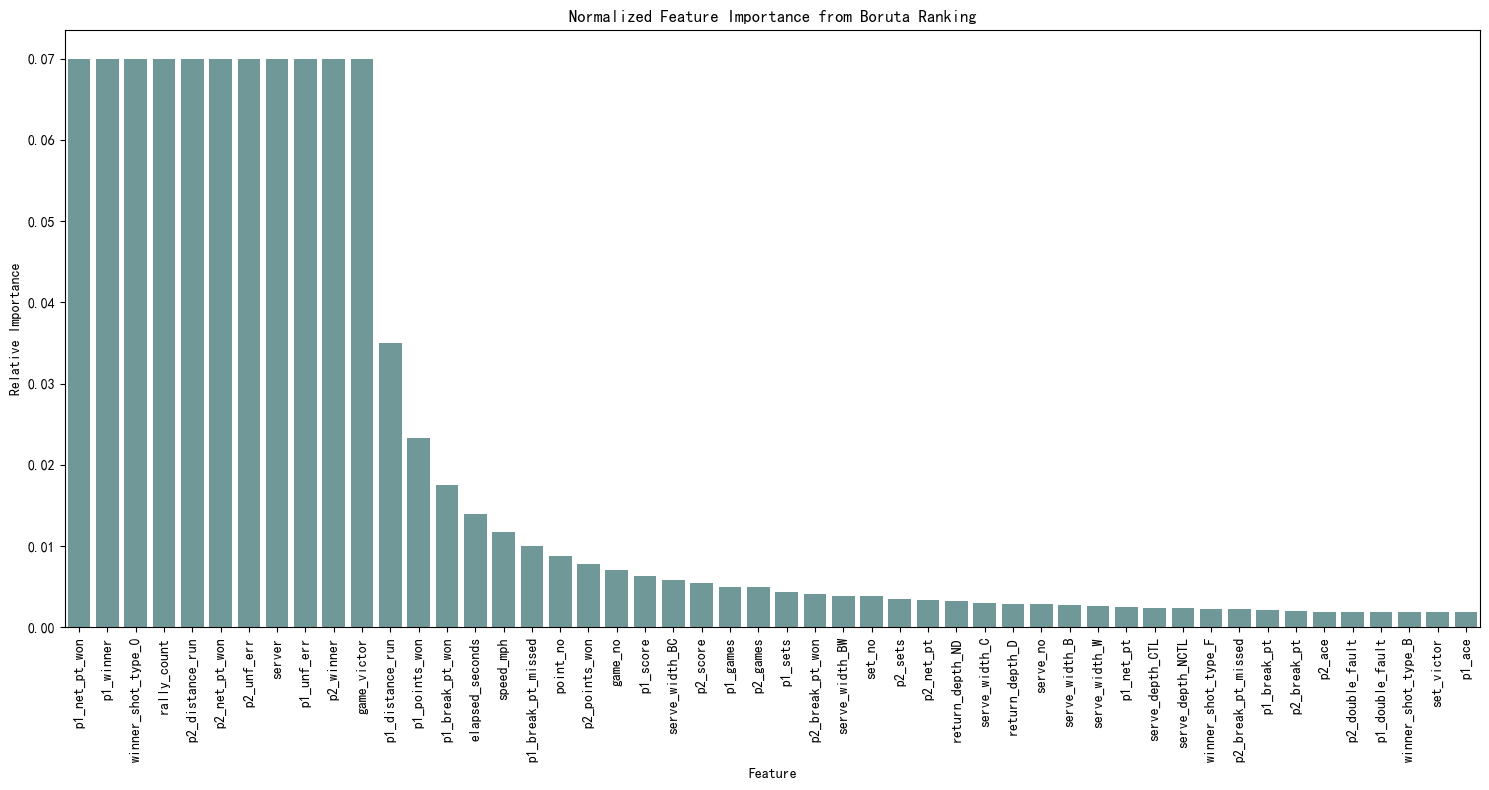

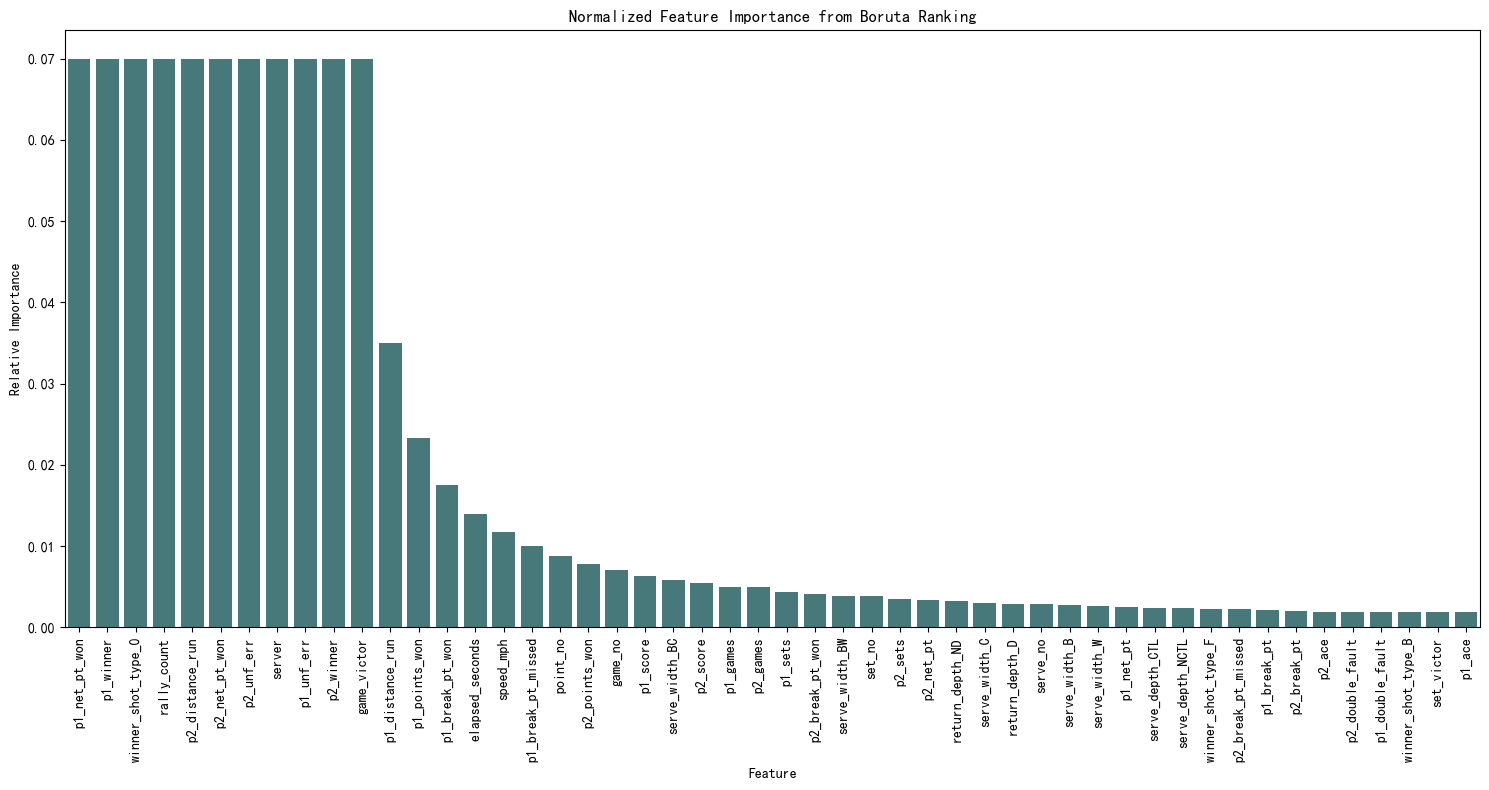

In [36]:
X = df1.drop(['match_id', 'player1', 'player2', 'elapsed_time', 'point_victor'], axis=1)
y = df1['point_victor']

forest = RandomForestRegressor(n_jobs=-1, max_depth=20)
# boruta = BorutaPy(estimator=forest, n_estimators='auto', max_iter=200)

# boruta.fit(np.asarray(X), np.asarray(y))
# ranking = boruta.ranking_
# importance_scores = 1 / ranking
# importance_scores_normalized = importance_scores / importance_scores.sum()
importance_df = pd.read_csv("../data/boruta_importence.csv")
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# 可视化重要性
for c in color:
    plt.figure(figsize=(15, 8))
    sns.barplot(data=importance_df, x='Feature', y='Importance', color=c)
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Relative Importance')
    plt.title('Normalized Feature Importance from Boruta Ranking')
    plt.tight_layout()
    plt.show()

In [407]:
df1.to_csv('data.csv', index=False)